## Machine Learning Discount Predictions, using US Retail Data

As one of the most frugal species on the planet (a university student), I take *every* and *any* chance to save money. Ask any university student what they spend the most time worrying about, and they'll probably respond with something related to the dollar sign (tuition, groceries, getting a job etc, etc). After almost a year as a university student, my favourite thing to see plastered on a store front is the 8-letter word, *discount*.

**This dilemma inspired me to create a ML project, predicting the application of discounts based on various factors.** My project uses the Retail Data dataset posted by Abdur Raziq Khan at [Kaggle.com](https://www.kaggle.com/datasets/abdurraziq01/retail-data?resource=download ), which includes interesting categories such as store location, payment method, and purchase date, to name a few. These features will be preprocessed and analyzed. The, using the Random Forrest Classifier technique, I will train a machine learning model that will predict whether or not a discount has been applied based on the features we used. We will also take a look at feature importance to identify key factors influencing the outcome, providing more insights on relationships within the dataset, and motivating topics to look into in future projects. Without further ado, let's get into it!

In [80]:
# importing libraries
from sqlalchemy import create_engine, text

from dotenv import load_dotenv
import os

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv('SQLinformation.env')

db_host = os.getenv("MYSQL_HOST")
db_user = os.getenv("MYSQL_USER")
db_password = os.getenv("MYSQL_PASSWORD")
db_name = os.getenv("MYSQL_DATABASE")

# creating an engine to interact with the database
engine = create_engine(f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}")

# establishing connection with MySQL database
try:
    with engine.connect() as connection:
        print("Connected to MySQL database using SQLAlchemy")
except Exception as e:
    print("Error while connecting to MySQL:", e)

# loading retail_data into a Pandas DataFrame
query = "SELECT * FROM retail_data"
retail_df = pd.read_sql(query, engine)
retail_df.head()

Connected to MySQL database using SQLAlchemy


,CustomerID,Age,Gender,AnnualIncome,SpendingScore,ProductCategory,ProductPrice,PurchaseDate,StoreID,StoreLocation,PaymentMethod,DiscountApplied,DiscountPercent,ProductCost,Profit,FootTraffic,InventoryLevel,MarketingExpenditure,CompetitorPrice
0,1,58,Male,60038,41,Health & Beauty,147.43,2022-06-11,46,San Jose,Credit Card,1.0,26,109.10,38.33,336,26,9107.90,171.55
1,2,57,Male,31577,91,Health & Beauty,402.09,2023-06-05,53,Los Angeles,Mobile Payment,1.0,1,398.07,4.02,491,32,1746.77,419.19
2,3,39,Female,117404,26,Groceries,958.45,2020-10-14,95,Philadelphia,Mobile Payment,0.0,0,958.45,0.00,157,3,2030.49,835.92
3,4,33,Male,87434,94,Electronics,544.17,2021-08-27,24,Dallas,Credit Card,0.0,0,544.17,0.00,223,87,6242.68,620.36
4,5,18,Male,90225,10,Health & Beauty,645.75,2023-06-06,2,San Antonio,Credit Card,0.0,0,645.75,0.00,315,8,6008.89,600.49


I used the Retail Data dataset in a previous dataset where I analyzed the data through MySQL tables and Matplotlib visualizations. The same dataset is used in this project, with the first 5 rows of the retail_data table on my MySQL database shown above. Note that the table has 19 columns: **CustomerID, Age, Gender, AnnualIncome, SpendingScore, ProductCategory, ProductPrice, PurchaseDate, StoreID, StoreLocation, PaymentMethod, DiscountApplied, DiscountPerfect, ProductCost, Profit, FootTraffic, InventoryLevel, MarketingExpenditure, and CompetitorPrice**. I chose to focus on the column with boolean values: DiscountApplied. In the original dataset on Kaggle, the values were strings of either True or False, but using UPDATE and ALTER SQL queries, I changed those values into integers 0/1. Changing our categorical data into numerical data will allow us to use Scikit-learn & Random Forest.
Since the data has been loaded into a Pandas dataframe above, we can do our cleaning/preprocessing and pretty much the entirety of the rest of our work outside of MySQL.

In [85]:
# removing null values
print(retail_df.isnull().sum())
retail_df = retail_df.dropna()
retail_df = retail_df.drop_duplicates()

CustomerID              0
Age                     0
Gender                  0
AnnualIncome            0
SpendingScore           0
ProductCategory         0
ProductPrice            0
PurchaseDate            0
StoreID                 0
StoreLocation           0
PaymentMethod           0
DiscountApplied         0
DiscountPercent         0
ProductCost             0
Profit                  0
FootTraffic             0
InventoryLevel          0
MarketingExpenditure    0
CompetitorPrice         0
PurchaseDate_days       0
dtype: int64


Now the data has no null or duplicate values, but we still have to change somethings before training our ML model on it. First, we will ensure the values under PurchaseDate are all in a datetime format (YYYY-MM-DD). This will allow us to calculate the difference in days between the purchase date and the earliest date in the dataset - resulting in a timedelta object that is stored under the new PurchaseDate_days column.

In [86]:
retail_df["PurchaseDate"] = pd.to_datetime(retail_df["PurchaseDate"], errors='coerce')
# Convert PurchaseDate to the number of days since a reference date (e.g., the first date in the dataset)
retail_df["PurchaseDate_days"] = (retail_df["PurchaseDate"] - retail_df["PurchaseDate"].min()).dt.days
retail_df["PurchaseDate_days"].head()

0     697
1    1056
2      92
3     409
4    1057
Name: PurchaseDate_days, dtype: int64

The next step is to select the features we want to use with our model. Notice that PurchaseDate has been replaced with PurchaseDate_days. I have decided to use pretty much all of the columns except:
1. DiscountApplied (since this is what we're predicting)
2. CustomerID and StoreID
3. DiscountPercent
4. Profit (since this is a *result* of a discount applied. It doesnt make sense to predict something based on something that results from it.)

Then, we'll use the *pandas.get_dummies* function to transform our categorical columns into binary columns. Essentially, each category under the column will become it's own column, and its values will either be 0 or 1. However, to prevent the **dummy variable trap**, a situation where there are redundant dummy variables, we use *drop_first=True* to drop one category for each column. Finally, we set our target variable to be the DiscountApplied column. This will be the output our ML model will predict based on the features in x.

In [87]:
x = retail_df[["Age", "Gender", "AnnualIncome", "SpendingScore", "ProductCategory", "PurchaseDate_days", "StoreLocation", "PaymentMethod", "ProductCost", "ProductPrice", "FootTraffic", "InventoryLevel", "MarketingExpenditure", "CompetitorPrice"]] 
x = pd.get_dummies(x, drop_first=True) # transform categorial columns into binary columns

y = retail_df["DiscountApplied"]
x.head()

,Age,AnnualIncome,SpendingScore,PurchaseDate_days,ProductCost,ProductPrice,FootTraffic,InventoryLevel,MarketingExpenditure,CompetitorPrice,...,StoreLocation_New York,StoreLocation_Philadelphia,StoreLocation_Phoenix,StoreLocation_San Antonio,StoreLocation_San Diego,StoreLocation_San Jose,PaymentMethod_Credit Card,PaymentMethod_Debit Card,PaymentMethod_Mobile Payment,PaymentMethod_Online Transfer
0,58,60038,41,697,109.10,147.43,336,26,9107.90,171.55,...,False,False,False,False,False,True,True,False,False,False
1,57,31577,91,1056,398.07,402.09,491,32,1746.77,419.19,...,False,False,False,False,False,False,False,False,True,False
2,39,117404,26,92,958.45,958.45,157,3,2030.49,835.92,...,False,True,False,False,False,False,False,False,True,False
3,33,87434,94,409,544.17,544.17,223,87,6242.68,620.36,...,False,False,False,False,False,False,True,False,False,False
4,18,90225,10,1057,645.75,645.75,315,8,6008.89,600.49,...,False,False,False,True,False,False,True,False,False,False


Next, we'll split the dataset into training and testing subsets. 80% of the data will be used to train the model, while the remaining 20% will be used to evaluate its performance. The, we choose a random seed of 42 to ensure that the split is reproducible, and we get the same train-test split *everytime* we run the code. I've chosen to build 200 decision trees, and using the Random Forest technique, the predictions of these trees will be combined to improve accuracy and reduce overfitting.
The last step is to actually train the model with our training subsets. The trained model can then be used to predict the target variable for the testing subset, and we store those predicted values into *y_pred*.

In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

The values in *y_pred* can be compared with the actual values in *y_test*. To compare the values and evaluate the performance of our mode, we can find four values: Accuracy, Precision, Recall, and F1 Score.
<br>**Accuracy** is the proportion of correct predictions to the total number of predictions. This tells us the overall correctness, but can be unreliable in imbalanced datasets.
<br>**Precision** is the proportion of true positive predictions to the total number of true AND false positives. This tells us how reliable the positive predictions are.
<br>**Recall** is the proportion of true positive predictions to true positives and false negatives. This tells us how well the model predicts actual positive instances.
<br>**F1 Score** is the harmonic mean of precision and recall. It tells us the balance between precision and recall and is useful when the dataset is imbalanced, or if there's no clear preference between false positives and false negatives. In the case of predicting DiscountApplied, there isn't a clear preference. A false positive would mean that the model predicts a discount has been applied when it hasn't, and a false negative would mean that the model predicts a discount has not been applied when it has.

In [89]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Accuracy: 0.849493487698987
Precision: 0.8780415430267062
Recall: 0.801462621885157
F1 Score: 0.838006230529595


Our accuracy, precicion, recall, and F1 values are decent! As mentioned before, accuracy can be misleading when it comes to imbalanced datasets, so let's take a look at the frequency of 1s and 0s in the DiscountApplied column.

In [90]:
discount_counts = retail_df['DiscountApplied'].value_counts()
print(discount_counts)

DiscountApplied
0.0    19033
1.0    18972
Name: count, dtype: int64


The dataset seems to be fairly evenly split between discounts applied vs discounts not applied. Then the accuracy, precision, and recall scores tell us that the model is fairly reliable in overall correctness, decent in its positive predictions, and in predicting positive instances. Let's take a deeper dive and look at the feature importances.

In [91]:
feature_importance = model.feature_importances_
features = x.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                            Feature  Importance
4                       ProductCost    0.213711
5                      ProductPrice    0.180955
9                   CompetitorPrice    0.089858
8              MarketingExpenditure    0.062319
1                      AnnualIncome    0.061789
3                 PurchaseDate_days    0.060624
6                       FootTraffic    0.060235
7                    InventoryLevel    0.054625
2                     SpendingScore    0.054367
0                               Age    0.049887
10                      Gender_Male    0.009015
27     PaymentMethod_Mobile Payment    0.006907
25        PaymentMethod_Credit Card    0.006849
28    PaymentMethod_Online Transfer    0.006831
26         PaymentMethod_Debit Card    0.006794
11         ProductCategory_Clothing    0.006309
12      ProductCategory_Electronics    0.006190
15   ProductCategory_Home & Kitchen    0.006090
13        ProductCategory_Groceries    0.006030
14  ProductCategory_Health & Beauty    0

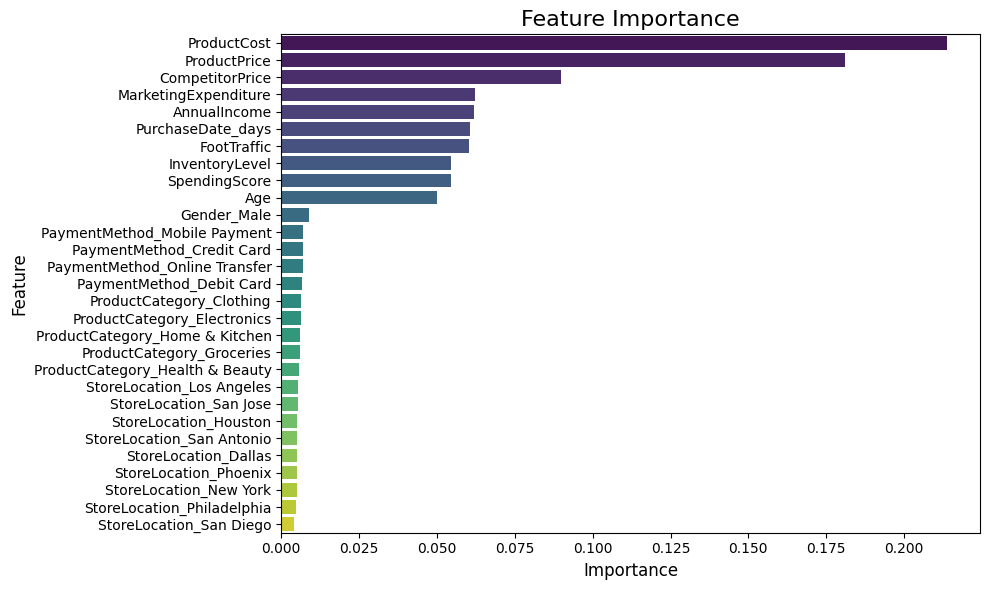

In [92]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, hue="Feature", dodge=False, palette="viridis")
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

As shown in the visualization above, the top ten most importance features were **ProductCost, CompetitorPrice, MarketingExpenditure, AnnualIncome, FootTraffic, PurchaseDate_days, InventoryLevel, SpendingScore, Age, and Gender_Male**. Much of these findings align with domain knowledge. The day of the year determines whether or not there will be seasonal discounts. Customers with higher spending scores/annual incomes may be able to purchase more, and enjoy tiered discounts. Markets and competitor prices also influenced whether or not a firm will decide to apply a discount. Some discounts may be age related - for example senoir discounts. The feature importances confirms a lot of our current knowledge, but one finding surprised me - product category is not very important to our model's predictions!
<br>Now that we know which features are actually significant to our model, we can train a simpler model with a smaller set of features, to hopefully eliminate irrelevant variables and increase accuracy/precision. As a benchmark, I'm choosing the features with an importance greater than 0.07. That includes the top 7 features.

In [93]:
x2 = retail_df[["ProductCost", "ProductPrice", "CompetitorPrice", "MarketingExpenditure", "AnnualIncome", "PurchaseDate_days", "FootTraffic"]] 
# we don't have any categorical columns in this selection, so no need to use pd.get_dummies.
y2 = retail_df["DiscountApplied"]
x2.head()

,ProductCost,ProductPrice,CompetitorPrice,MarketingExpenditure,AnnualIncome,PurchaseDate_days,FootTraffic
0,109.10,147.43,171.55,9107.90,60038,697,336
1,398.07,402.09,419.19,1746.77,31577,1056,491
2,958.45,958.45,835.92,2030.49,117404,92,157
3,544.17,544.17,620.36,6242.68,87434,409,223
4,645.75,645.75,600.49,6008.89,90225,1057,315


In [94]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(x2_train, y2_train)
y2_pred = model.predict(x2_test)

In [95]:
print(f"Accuracy: {accuracy_score(y2_test, y2_pred)}")
print(f"Precision: {precision_score(y2_test, y2_pred)}")
print(f"Recall: {recall_score(y2_test, y2_pred)}")
print(f"F1 Score: {f1_score(y2_test, y2_pred)}")

Accuracy: 0.926062360215761
Precision: 0.9785932721712538
Recall: 0.866738894907909
F1 Score: 0.9192760700948004


That's better! Note that our precision is now almost perfect. This means that the model's positive predictions are very reliable. The F1 score also indicates a good balance between precision and recall. Ultimately, the importance of the precision/recall values depends on the what we're trying to do. If false positives are especially costly/harmful, it's recommended to focus on precision. If false negatives are costly/harmful, then the focus should be on recall. In our situation, a false positive might mean a consumer will try and purchase something under the impression that there's a discount, only to be met with a higher price than expected. A false negative might mean a consumer is unaware of a discount, missing out on savings. There isn't a clear preference between the two, so I'll keep our F1 score decently high and leave it as that!
<br>Overall, this project has reinforced my understanding of money, economics, and discounts, while teaching me new things. There were some bumps along the road with my first model, but I was able to apply my knowledge on feature importance to train a more precise model. As a next step, further analysis on individual relationships between our top features and discount application can be done.